# CF rating system improvement
## Main idea:
Only hyperparameters used in prediciting places with codeforce ranking system are in the probability formula. The motivation behind this idea is trying to minimize the predicted probability error of contestant $A$ winning against contestant $B$. 

If we could somehow predict that $A$ is going to lose against excactly $k$ other competitors we would know he's going to be $k+1-th$. 

## Algorithm
Instead of trying to find optimal parameters by randomiziation and observations (done by hand). I've opted for a simple nerual network. 

Currently the net has 3 hidden layers with $\operatorname{tanh}$ activation functions. 

Activation function on the last layer is $\operatorname{sigmoid}$.

I'm using MSE as a loss function and AdamOptimizer for optimization. 

I'm splitting the data in $80/ 20$ ratio for training and testing sets. Also batching the samples with $batchsize = 128$.

## Data
Since I've really wanted to have 'momentum' included in my rating vector therefore I've had 2 main options of generating data.

1. Going from the beginning of the contests and generating the data myself.
2. Using users' history provided by codeforces API. Only those consider active are included in it.

I've tried both of those approaches.

## Results
Results are very poor. In every approach I've tried NN was estimating the mean value of expected outputs for every input (which is statistically correct if it can't find any strong patterns).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from database import Database, LoadDatabase
import random

In [145]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(6, 50)
        self.layer2 = nn.Linear(50, 25)
        self.layer3 = nn.Linear(25, 10)
        self.layer4 = nn.Linear(10,1)
    
    def forward(self, x):
        x = F.tanh(self.layer1(x))
        x = F.tanh(self.layer2(x))
        x = F.tanh(self.layer3(x))
        x = F.sigmoid(self.layer4(x))
        return x

def save_nn():
    torch.save(net.state_dict(), PATH)

In [3]:
DB = LoadDatabase()

In [38]:
def ProcessUser(data, contests):
    currentDeltaSum = 0
    contestsCounter = 0
    participatedContests = set()
    expectedDelta = {}
    prevTime = 0
    elapsedTime = {}
    for key, row in data.iterrows():
        contestsCounter += 1
        if key == 0:
            currentDeltaSum += (row['newRating'] - 1500)
            elapsedTime[row['contestId']] = 0
        else:
            currentDeltaSum += (row['delta'])
            elapsedTime[row['contestId']] = ... - prevTime
        participatedContests.add(row['contestId'])
        expectedDelta[row['contestId']] = (currentDeltaSum / contestsCounter)
    return (participatedContests, expectedDelta)

In [39]:
class UserData:
    def __init__(self, userData, contestsData):
        self.contests = set()
        self.expectedDelta = {}
        self.elapsedTime = {}
        self.rank = {}
        self.rating = {}
        
        currentDeltaSum = 0
        contestsCounter = 0
        prevTime = 0
        
        for k, row in userData.iterrows():
            contestId = row['contestId']
            contestsCounter += 1
            newTime = contestsData.loc[contestId]['startTime']
            if k == 0:
                currentDeltaSum += (row['newRating'] - 1500)
                self.elapsedTime[contestId] = 0
                self.rating[contestId] = 1500
            else:
                self.rating[contestId] = row['oldRating']
                currentDeltaSum += (row['delta'])
                self.elapsedTime[contestId] = newTime - prevTime
            prevTime = newTime
            self.contests.add(contestId)
            self.expectedDelta[contestId] = (currentDeltaSum / contestsCounter)
            self.rank[contestId] = row['rank']
            
    def GenVecs(self, other):
        data = []
        commonContests = self.contests & other.contests
        for c in commonContests:
            arr = np.array([
                self.rating[c], 
                self.elapsedTime[c],
                self.expectedDelta[c],
                other.rating[c], 
                other.elapsedTime[c],
                other.expectedDelta[c],
                self.AmIBetter(self.rank[c], other.rank[c])
            ])
            data.append(arr)
        return data
    
    def AmIBetter(self, rank, otherRank):
        if rank < otherRank:
            return 1
        return 0

In [40]:
class Dataset:
    def __init__(self, db):
        self.history = db.history
        self.contests = db.contests
    
    def genDataset(self):
        dataset = []
        usersData = {}
        for name, hist in self.history.items():
            usersData[name] = UserData(hist, self.contests)
        
        for name, data in usersData.items():
            for otherName, otherData in usersData.items():
                arr = data.GenVecs(otherData)
                dataset.extend(arr)
        return dataset

In [41]:
dataset = Dataset(DB)

In [116]:
nnInputTotal = dataset.genDataset()

In [188]:
nnInput = nnInputTotal
random.shuffle(nnInput)
print("Done shuffling")
#trainSize = int(len(nnInput)*0.8)
cutSize = int(len(nnInput)*0.01)
nnInput = nnInput[:cutSize]
trainSize = int(len(nnInput)*0.8)
trainSet = nnInput[:trainSize]
testSet = nnInput[trainSize:]

trainX = []
trainY = []
for data in trainSet:
    x = torch.tensor(data[:6], dtype = torch.float, requires_grad=True)
    y = torch.tensor(data[-1], dtype = torch.float, requires_grad=True)
    trainX.append(x)
    trainY.append(y)
trainX = torch.stack(trainX)
trainY = torch.stack(trainY)

testX = []
testY = []
for data in testSet: 
    x = torch.tensor(data[:6], dtype = torch.float, requires_grad=True)
    y = torch.tensor(data[-1], dtype = torch.float, requires_grad=True)
    testX.append(x)
    testY.append(y)

batchSize = 32

323485
Done shuffling


In [189]:
errs = []

PATH = './prob_net63.pth'
net = Net()
#net.load_state_dict(torch.load(PATH))
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(1000):
    print("Epoch ", epoch, " started")
    c = 0
    i = 0
    while i < len(trainX):
        #print("Bach", int(i/batchSize) ,"started")
        x = trainX[i:i+batchSize]
        y = trainY[i:i+batchSize]
        i += batchSize
        output = net(x)
        loss = criterion(output, y)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        #print("Bach finished")
    
    err = 0
    #torch.save(net.state_dict(), "./net-" + str(epoch) + ".pth")
    for i in range(len(testX)):
        output = net(testX[i])
        err += abs(output.detach().numpy()[0] - testY[i].detach().numpy())
    err = err/len(testX)
    print("Epoch: ", epoch, ", error: ", err)
    errs.append((epoch,err))
        
            
print('Finished Training')

Epoch  0  started


/home/mike/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:  0 , error:  0.49730330908316916
Epoch  1  started
Epoch:  1 , error:  0.4971629874967902
Epoch  2  started
Epoch:  2 , error:  0.49736017937638105
Epoch  3  started
Epoch:  3 , error:  0.49759947079042377
Epoch  4  started
Epoch:  4 , error:  0.4977165069978057
Epoch  5  started
Epoch:  5 , error:  0.49788298746902016
Epoch  6  started
Epoch:  6 , error:  0.4979649438555863
Epoch  7  started
Epoch:  7 , error:  0.49803395746664436
Epoch  8  started
Epoch:  8 , error:  0.49810917267843596
Epoch  9  started
Epoch:  9 , error:  0.4981618986063431
Epoch  10  started
Epoch:  10 , error:  0.49821638443739
Epoch  11  started
Epoch:  11 , error:  0.49823733869439113
Epoch  12  started
Epoch:  12 , error:  0.4982802884011217
Epoch  13  started
Epoch:  13 , error:  0.49828514793003914
Epoch  14  started
Epoch:  14 , error:  0.4983247974095794
Epoch  15  started
Epoch:  15 , error:  0.4983228607192474
Epoch  16  started
Epoch:  16 , error:  0.49835414735390193
Epoch  17  started
Epoch:  1

Epoch:  138 , error:  0.4985738739808892
Epoch  139  started
Epoch:  139 , error:  0.49857924176146845
Epoch  140  started
Epoch:  140 , error:  0.4985752377480591
Epoch  141  started
Epoch:  141 , error:  0.4985776750897698
Epoch  142  started
Epoch:  142 , error:  0.4985747100580973
Epoch  143  started
Epoch:  143 , error:  0.4985768454612868
Epoch  144  started
Epoch:  144 , error:  0.49857351791913945
Epoch  145  started
Epoch:  145 , error:  0.4985794916495658
Epoch  146  started
Epoch:  146 , error:  0.49857511793995934
Epoch  147  started
Epoch:  147 , error:  0.49858351818745067
Epoch  148  started
Epoch:  148 , error:  0.49857870154255507
Epoch  149  started
Epoch:  149 , error:  0.49858715711089524
Epoch  150  started
Epoch:  150 , error:  0.49858393998013395
Epoch  151  started
Epoch:  151 , error:  0.4985914134076427
Epoch  152  started
Epoch:  152 , error:  0.49859050367678154
Epoch  153  started
Epoch:  153 , error:  0.49859790584587793
Epoch  154  started
Epoch:  154 , e

Epoch:  272 , error:  0.49858972784909067
Epoch  273  started
Epoch:  273 , error:  0.49858533741886135
Epoch  274  started
Epoch:  274 , error:  0.49859396456935123
Epoch  275  started
Epoch:  275 , error:  0.4985884899241847
Epoch  276  started
Epoch:  276 , error:  0.49858266672542695
Epoch  277  started
Epoch:  277 , error:  0.4985812801113453
Epoch  278  started
Epoch:  278 , error:  0.4985793573778969
Epoch  279  started
Epoch:  279 , error:  0.4985925872598586
Epoch  280  started
Epoch:  280 , error:  0.4985857109382311
Epoch  281  started
Epoch:  281 , error:  0.4985871252357683
Epoch  282  started
Epoch:  282 , error:  0.4985791109905361
Epoch  283  started
Epoch:  283 , error:  0.49858270610871236
Epoch  284  started
Epoch:  284 , error:  0.49857286848646043
Epoch  285  started
Epoch:  285 , error:  0.4985757208036308
Epoch  286  started
Epoch:  286 , error:  0.498548067104319
Epoch  287  started
Epoch:  287 , error:  0.49859540111499
Epoch  288  started
Epoch:  288 , error: 

Epoch:  406 , error:  0.498560766025894
Epoch  407  started
Epoch:  407 , error:  0.49855195177025186
Epoch  408  started
Epoch:  408 , error:  0.49855502656843786
Epoch  409  started
Epoch:  409 , error:  0.4985535907597962
Epoch  410  started
Epoch:  410 , error:  0.4985499984974839
Epoch  411  started
Epoch:  411 , error:  0.49854811510125857
Epoch  412  started
Epoch:  412 , error:  0.4985487203141084
Epoch  413  started
Epoch:  413 , error:  0.49854937462939364
Epoch  414  started
Epoch:  414 , error:  0.4985532433117007
Epoch  415  started
Epoch:  415 , error:  0.4985318791460954
Epoch  416  started
Epoch:  416 , error:  0.49852272310802337
Epoch  417  started
Epoch:  417 , error:  0.49853088286413105
Epoch  418  started
Epoch:  418 , error:  0.4985492255717193
Epoch  419  started
Epoch:  419 , error:  0.4985397195060618
Epoch  420  started
Epoch:  420 , error:  0.49853345931405446
Epoch  421  started
Epoch:  421 , error:  0.49854541580312217
Epoch  422  started
Epoch:  422 , err

Epoch:  540 , error:  0.49853991614611476
Epoch  541  started
Epoch:  541 , error:  0.4985237938727625
Epoch  542  started
Epoch:  542 , error:  0.4985423276468628
Epoch  543  started
Epoch:  543 , error:  0.49851726831571763
Epoch  544  started
Epoch:  544 , error:  0.4985370001708153
Epoch  545  started
Epoch:  545 , error:  0.4985226336549939
Epoch  546  started
Epoch:  546 , error:  0.4985341540720584
Epoch  547  started
Epoch:  547 , error:  0.49853548449010715
Epoch  548  started
Epoch:  548 , error:  0.498533304360403
Epoch  549  started
Epoch:  549 , error:  0.4985234872358844
Epoch  550  started
Epoch:  550 , error:  0.4985211623323019
Epoch  551  started
Epoch:  551 , error:  0.49851418531843833
Epoch  552  started
Epoch:  552 , error:  0.4985318401313086
Epoch  553  started
Epoch:  553 , error:  0.4985125392813587
Epoch  554  started
Epoch:  554 , error:  0.4985405571493889
Epoch  555  started
Epoch:  555 , error:  0.4985281370430494
Epoch  556  started
Epoch:  556 , error: 

Epoch:  674 , error:  0.49851216313643654
Epoch  675  started
Epoch:  675 , error:  0.49855046146988313
Epoch  676  started
Epoch:  676 , error:  0.4984958006020123
Epoch  677  started
Epoch:  677 , error:  0.49854611466067283
Epoch  678  started
Epoch:  678 , error:  0.49851985849221303
Epoch  679  started
Epoch:  679 , error:  0.4985206799216027
Epoch  680  started
Epoch:  680 , error:  0.49853160240366434
Epoch  681  started
Epoch:  681 , error:  0.49851404229492824
Epoch  682  started
Epoch:  682 , error:  0.49852877790813654
Epoch  683  started
Epoch:  683 , error:  0.49852708691423053
Epoch  684  started
Epoch:  684 , error:  0.4985088560459603
Epoch  685  started
Epoch:  685 , error:  0.49854015976973626
Epoch  686  started
Epoch:  686 , error:  0.4985088137607486
Epoch  687  started
Epoch:  687 , error:  0.4985314065006085
Epoch  688  started
Epoch:  688 , error:  0.4985235671540132
Epoch  689  started
Epoch:  689 , error:  0.4985141806661438
Epoch  690  started
Epoch:  690 , e

Epoch:  808 , error:  0.49849229562780034
Epoch  809  started
Epoch:  809 , error:  0.4985015918335185
Epoch  810  started
Epoch:  810 , error:  0.4985048425437125
Epoch  811  started
Epoch:  811 , error:  0.49849375888958597
Epoch  812  started
Epoch:  812 , error:  0.4985031788187012
Epoch  813  started
Epoch:  813 , error:  0.4984906167482851
Epoch  814  started
Epoch:  814 , error:  0.4984942168411921
Epoch  815  started
Epoch:  815 , error:  0.49850427874089026
Epoch  816  started
Epoch:  816 , error:  0.4984861791963002
Epoch  817  started
Epoch:  817 , error:  0.4985033653711057
Epoch  818  started
Epoch:  818 , error:  0.4984930160425177
Epoch  819  started
Epoch:  819 , error:  0.49849506084111966
Epoch  820  started
Epoch:  820 , error:  0.498505093168807
Epoch  821  started
Epoch:  821 , error:  0.4984900487537915
Epoch  822  started
Epoch:  822 , error:  0.4984984346298383
Epoch  823  started
Epoch:  823 , error:  0.4984921388777183
Epoch  824  started
Epoch:  824 , error: 

Epoch:  942 , error:  0.4984713332638306
Epoch  943  started
Epoch:  943 , error:  0.4984597719894863
Epoch  944  started
Epoch:  944 , error:  0.4984639000487291
Epoch  945  started
Epoch:  945 , error:  0.49846933466573773
Epoch  946  started
Epoch:  946 , error:  0.49845797592742364
Epoch  947  started
Epoch:  947 , error:  0.49846624908896836
Epoch  948  started
Epoch:  948 , error:  0.4984615371897932
Epoch  949  started
Epoch:  949 , error:  0.49846155220611016
Epoch  950  started
Epoch:  950 , error:  0.49847065909568455
Epoch  951  started
Epoch:  951 , error:  0.49845849988633734
Epoch  952  started
Epoch:  952 , error:  0.4984696404274317
Epoch  953  started
Epoch:  953 , error:  0.49845649999849945
Epoch  954  started
Epoch:  954 , error:  0.49846160236797893
Epoch  955  started
Epoch:  955 , error:  0.49846603324092703
Epoch  956  started
Epoch:  956 , error:  0.49845929423108165
Epoch  957  started
Epoch:  957 , error:  0.49846735085365024
Epoch  958  started
Epoch:  958 ,

In [190]:
Xs = []
Ys = []
for i in range(len(testX)):
        output = net(testX[i])
        Xs.append(output.detach().numpy()[0])
        Ys.append(testY[i].detach().numpy())

In [191]:
import matplotlib.pyplot as plt

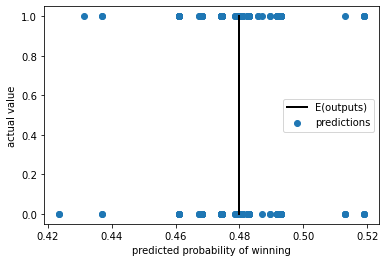

In [223]:
plt.plot([torch.mean(trainY),torch.mean(trainY)], [0, 1], color='k', linestyle='-', linewidth=2, label="E(outputs)")
plt.scatter(Xs,Ys,label="predictions")
plt.xlabel('predicted probability of winning')
plt.ylabel('actual value')
plt.legend(loc="best")
plt.savefig('trashnn.png')

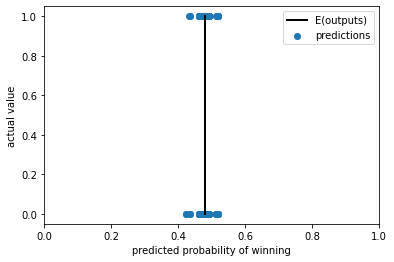

In [222]:
plt.plot([torch.mean(trainY),torch.mean(trainY)], [0, 1], color='k', linestyle='-', linewidth=2, label="E(outputs)")
plt.xlim(0,1)
plt.scatter(Xs,Ys, label="predictions")
plt.xlabel('predicted probability of winning')
plt.ylabel('actual value')
plt.legend(loc="best")
plt.savefig('trashnn2.png')

In [182]:
torch.mean(trainY)

tensor(0.4824, grad_fn=<MeanBackward0>)

In [183]:
torch.mean(torch.stack(testY))

tensor(0.5054, grad_fn=<MeanBackward0>)